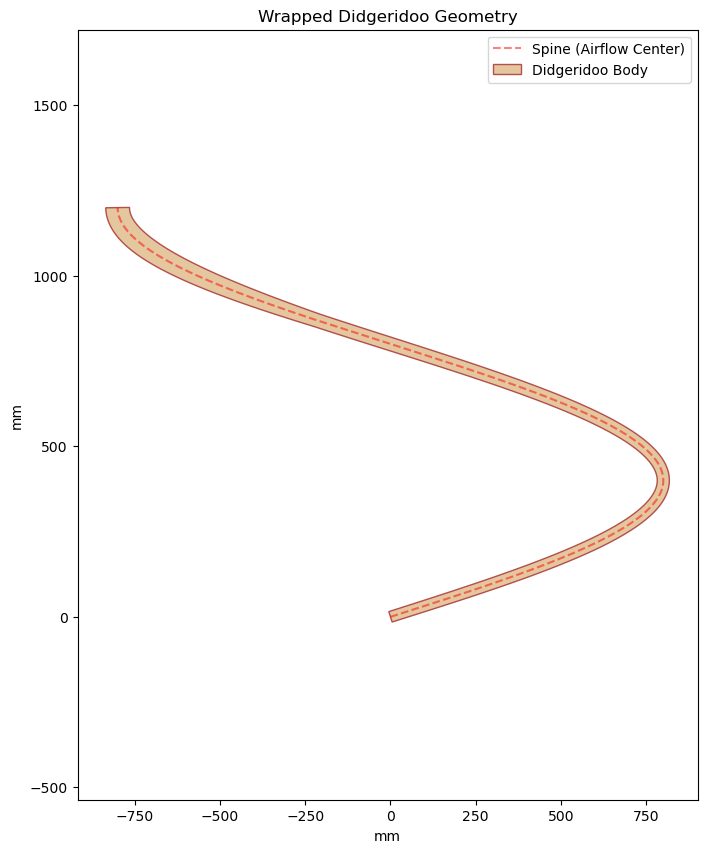

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 1. Define the didgeridoo segments [distance, diameter]
segments = np.array([[0, 32], [1200, 40], [1600, 70]])
distances = segments[:, 0]
diameters = segments[:, 1]

# Create an interpolator for the diameter based on distance
get_diameter = interp1d(distances, diameters, kind='linear')

# 2. Define the 2D Spine Curve (e.g., a gentle S-curve)
# Let's say the curve is defined over a parameter t from 0 to 1
t = np.linspace(0, 1, 500)
total_length = distances[-1]

# Example: A spiral-ish curve
# x(t) and y(t) should be scaled so the arc length matches total_length
x_spine = 800 * np.sin(1.5 * np.pi * t)
y_spine = 1200 * t

# 3. Calculate Arc Length and Normal Vectors
# Calculate local segments (dx, dy)
dx = np.gradient(x_spine)
dy = np.gradient(y_spine)

# Calculate cumulative arc length along the curve
segment_lengths = np.sqrt(dx**2 + dy**2)
arc_length = np.cumsum(segment_lengths)
# Normalize arc length to match the actual instrument length
arc_length = (arc_length - arc_length[0]) * (total_length / (arc_length[-1] - arc_length[0]))

# Calculate Normal Vectors (perpendicular to the tangent)
# For a 2D vector (dx, dy), the normal is (-dy, dx)
norms = np.sqrt(dx**2 + dy**2)
nx = -dy / norms
ny = dx / norms

# 4. Wrap the dimensions around the spine
upper_wall = []
lower_wall = []

for i in range(len(t)):
    d = get_diameter(arc_length[i])
    radius = d / 2
    
    # Offset the spine point by the radius along the normal
    upper_wall.append([x_spine[i] + nx[i] * radius, y_spine[i] + ny[i] * radius])
    lower_wall.append([x_spine[i] - nx[i] * radius, y_spine[i] - ny[i] * radius])

upper_wall = np.array(upper_wall)
lower_wall = np.array(lower_wall)

# 5. Visualization
plt.figure(figsize=(8, 10))
plt.plot(x_spine, y_spine, 'r--', label="Spine (Airflow Center)", alpha=0.5)
plt.fill(np.append(upper_wall[:,0], lower_wall[::-1,0]), 
         np.append(upper_wall[:,1], lower_wall[::-1,1]), 
         edgecolor='brown', facecolor='burlywood', alpha=0.8, label="Didgeridoo Body")

plt.axis('equal')
plt.title("Wrapped Didgeridoo Geometry")
plt.xlabel("mm")
plt.ylabel("mm")
plt.legend()
plt.show()

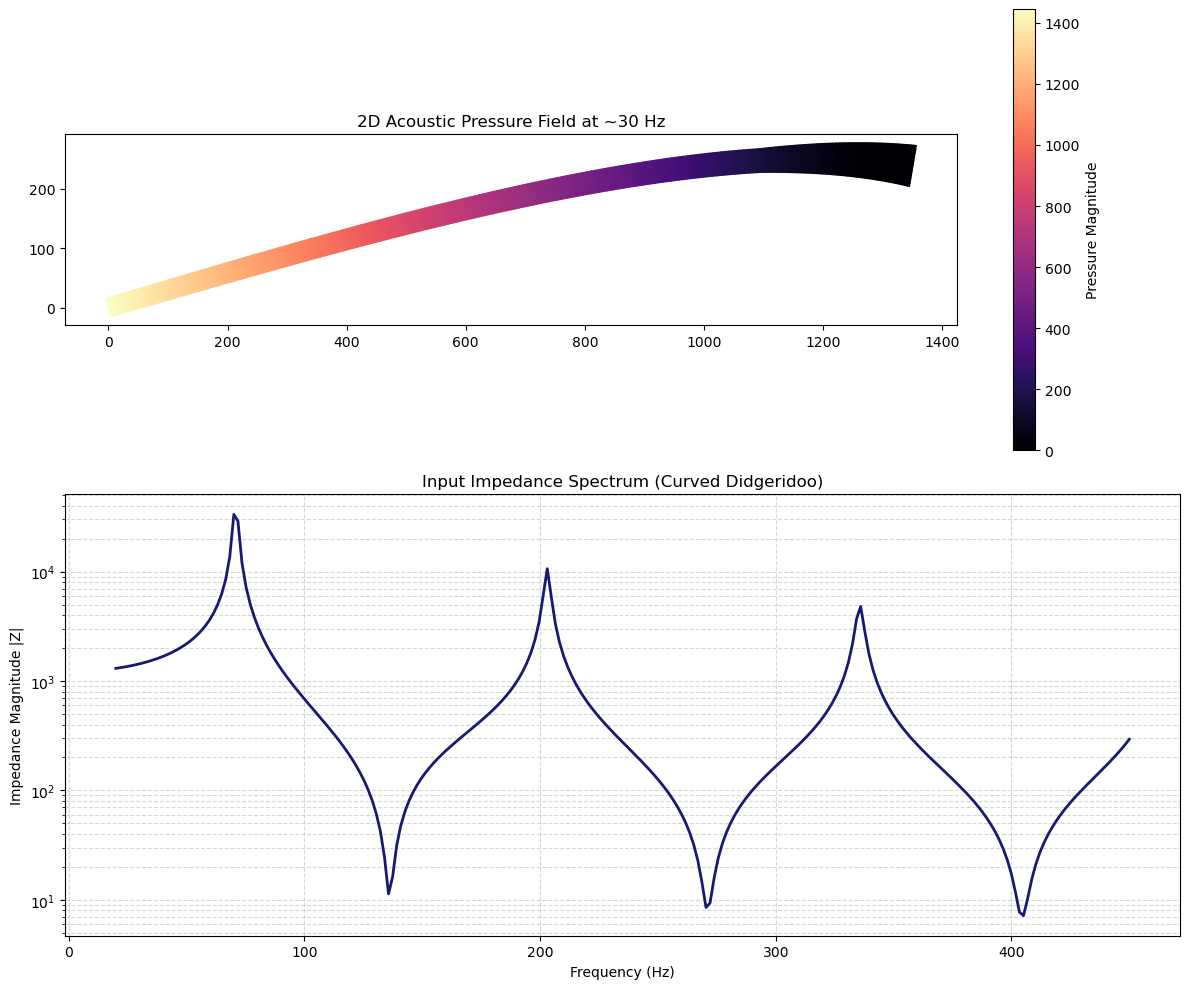

In [ ]:
import numpy as np
import skfem as fem
from skfem.helpers import dot, grad
import matplotlib.pyplot as plt

# 1. Didgeridoo Segments and Curve Definition
segments = np.array([[0, 32], [1200, 40], [1600, 70]])
c = 343000.0  # mm/s
frequencies = np.linspace(20, 450, 250)

def get_curve(s):
    """Defines an S-shaped curve for the didgeridoo."""
    theta = 0.6 * np.pi * (s / 1600.0)
    x = s * np.cos(theta * 0.3)
    y = 250 * np.sin(theta)
    return np.array([x, y])

def get_radius(s):
    return np.interp(s, segments[:, 0], segments[:, 1]) / 2.0

# 2. Build and Transform the Mesh
n_z, n_r = 200, 12
z_vals = np.linspace(0, segments[-1, 0], n_z)
r_vals = np.linspace(-1, 1, n_r) 

mesh_log = fem.MeshTri.init_tensor(z_vals, r_vals)
new_p = np.zeros_like(mesh_log.p)

# Transform coordinates to wrap around the curve
for i in range(mesh_log.p.shape[1]):
    s_val = mesh_log.p[0, i]
    rel_r = mesh_log.p[1, i]
    
    p0 = get_curve(s_val)
    p_eps = get_curve(s_val + 0.01)
    tangent = (p_eps - p0) / np.linalg.norm(p_eps - p0)
    normal = np.array([-tangent[1], tangent[0]]) 
    
    radius = get_radius(s_val)
    new_p[:, i] = p0 + (radius * rel_r * normal)

mesh = fem.MeshTri(new_p, mesh_log.t)
basis = fem.Basis(mesh, fem.ElementTriP1())

# 3. Define 2D Acoustic Bilinear Forms
@fem.BilinearForm
def stiffness(u, v, w):
    return dot(grad(u), grad(v))

@fem.BilinearForm
def mass(u, v, w):
    return u * v

K = stiffness.assemble(basis)
M = mass.assemble(basis)

# 4. Boundary and Source Handling
# Helper function to flatten DOF indices from skfem DOF objects
def get_flat_indices(dofs):
    if isinstance(dofs, dict):
        return np.concatenate([v for v in dofs.values()]).astype(int)
    return dofs.astype(int)

# Bell (Open end: Pressure = 0)
bell_pt = get_curve(1600.0)
bell_dofs = basis.get_dofs(lambda x: np.linalg.norm(x - bell_pt[:, None], axis=0) < 80)
bell_indices = get_flat_indices(bell_dofs.nodal)

# Mouthpiece (Source injection)
mouth_pt = get_curve(0.0)
mouth_dofs = basis.get_dofs(lambda x: np.linalg.norm(x - mouth_pt[:, None], axis=0) < 20)
mouth_indices = get_flat_indices(mouth_dofs.nodal)

b_mouth = np.zeros(basis.N)
b_mouth[mouth_indices] = 1.0

# 5. Frequency Sweep
impedance_spectrum = []
target_f = 65.0 
p_visual = None

for f in frequencies:
    omega = 2 * np.pi * f
    # Wave number with air damping
    k = (omega / c) - 1j * (1.5e-6 * np.sqrt(f))
    A = K - (k**2) * M
    
    # Solve system using condensation for Dirichlet BCs at the bell
    p = fem.solve(*fem.condense(A, b_mouth, D=bell_indices))
    p_mag = np.abs(p)
    
    # Impedance magnitude at mouthpiece
    impedance_spectrum.append(np.mean(p_mag[mouth_indices]))
    
    if np.abs(f - target_f) < (frequencies[1] - frequencies[0]):
        p_visual = p_mag

# 6. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: The Curved Pressure Field
# This visualizes how the sound wave travels through the bent tube

tpc = ax1.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, p_visual, 
                    cmap='magma', shading='gouraud')
ax1.set_title(f"2D Acoustic Pressure Field at ~{target_f} Hz")
ax1.set_aspect('equal')
fig.colorbar(tpc, ax=ax1, label='Pressure Magnitude')

# Plot 2: Impedance Spectrum
# Peaks correspond to the resonant frequencies (drones and overtones)
ax2.semilogy(frequencies, impedance_spectrum, color='midnightblue', lw=2)
ax2.set_title("Input Impedance Spectrum (Curved Didgeridoo)")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Impedance Magnitude |Z|")
ax2.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
import scipy
i = scipy.signal.find_peaks(impedance_spectrum)
frequencies[i[0]]


array([ 70.08032129, 203.05220884, 336.02409639])

Sweeping 500 frequencies...


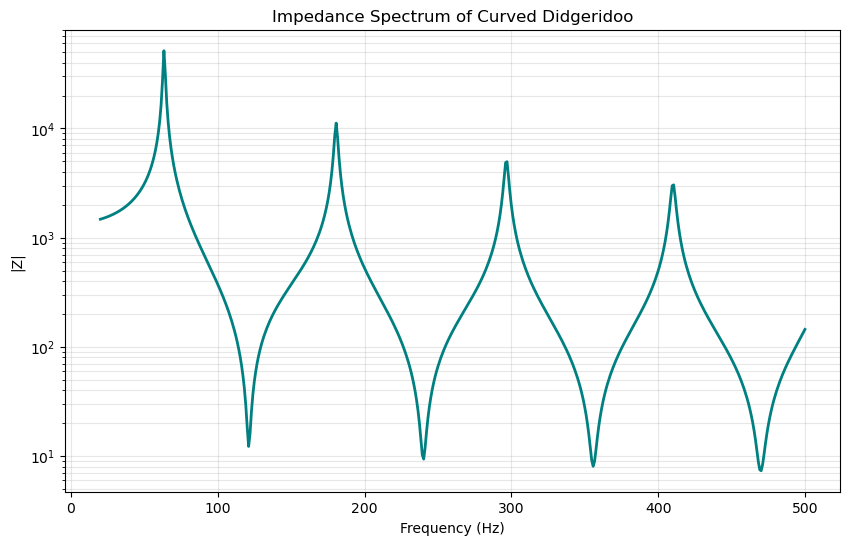

In [17]:
import numpy as np
import skfem as fem
from skfem.helpers import dot, grad
import matplotlib.pyplot as plt

# --- CONSTANTS ---
C_SPEED = 343000.0  # mm/s

# --- 1. GEOMETRY & MESHING ---

def get_didgeridoo_mesh(segments, curve_func, n_z=200, n_r=12):
    """
    Creates a 2D mesh wrapped around a parametric curve.
    """
    z_min, z_max = segments[0, 0], segments[-1, 0]
    z_vals = np.linspace(z_min, z_max, n_z)
    r_vals = np.linspace(-1, 1, n_r)
    
    # Initialize logical mesh
    mesh_log = fem.MeshTri.init_tensor(z_vals, r_vals)
    new_p = np.zeros_like(mesh_log.p)
    
    # Map to curved physical space
    for i in range(mesh_log.p.shape[1]):
        s_val = mesh_log.p[0, i]
        rel_r = mesh_log.p[1, i]
        
        p0 = curve_func(s_val)
        p_eps = curve_func(s_val + 0.1) # Small epsilon for tangent
        tangent = (p_eps - p0) / np.linalg.norm(p_eps - p0)
        normal = np.array([-tangent[1], tangent[0]])
        
        radius = np.interp(s_val, segments[:, 0], segments[:, 1]) / 2.0
        new_p[:, i] = p0 + (radius * rel_r * normal)
        
    return fem.MeshTri(new_p, mesh_log.t)

# --- 2. FEM OPERATORS ---

def assemble_acoustic_system(mesh):
    """
    Assembles the Stiffness (K) and Mass (M) matrices for the 2D wave equation.
    """
    basis = fem.Basis(mesh, fem.ElementTriP1())
    
    @fem.BilinearForm
    def stiffness(u, v, w):
        return dot(grad(u), grad(v))

    @fem.BilinearForm
    def mass(u, v, w):
        return u * v

    K = stiffness.assemble(basis)
    M = mass.assemble(basis)
    return K, M, basis

def get_boundary_indices(basis, curve_func, segments):
    """
    Identifies DOFs for the mouthpiece (source) and bell (open end).
    """
    def get_flat_indices(dofs):
        if isinstance(dofs, dict):
            return np.concatenate([v for v in dofs.values()]).astype(int)
        return dofs.astype(int)

    # Bell (Open end: Pressure = 0)
    bell_pt = curve_func(segments[-1, 0])
    bell_dofs = basis.get_dofs(lambda x: np.linalg.norm(x - bell_pt[:, None], axis=0) < 80)
    
    # Mouthpiece (Source)
    mouth_pt = curve_func(segments[0, 0])
    mouth_dofs = basis.get_dofs(lambda x: np.linalg.norm(x - mouth_pt[:, None], axis=0) < 20)
    
    return get_flat_indices(bell_dofs.nodal), get_flat_indices(mouth_dofs.nodal)

# --- 3. FREQUENCY ANALYSIS ---

def run_frequency_sweep(frequencies, K, M, basis, bell_idx, mouth_idx):
    """
    Performs a sweep over frequencies to calculate the input impedance.
    """
    z_spectrum = []
    
    # Pre-allocate source vector
    b_mouth = np.zeros(basis.N)
    b_mouth[mouth_idx] = 1.0
    
    for f in frequencies:
        omega = 2 * np.pi * f
        # k = omega/c with atmospheric damping
        k = (omega / C_SPEED) - 1j * (1.5e-6 * np.sqrt(f))
        
        A = K - (k**2) * M
        
        # Solve system: A * p = b
        p = fem.solve(*fem.condense(A, b_mouth, D=bell_idx))
        
        # Mean pressure magnitude at mouthpiece is proportional to Impedance
        z_spectrum.append(np.mean(np.abs(p[mouth_idx])))
        
    return np.array(z_spectrum)


# Define instrument
my_segments = np.array([[0, 32], [1200, 40], [1600, 70]])

def my_curve(s):
    # A simple spiral or S-curve
    angle = 0.5 * np.pi * (s / 1600.0)
    return np.array([s * np.cos(angle * 0.2), 300 * np.sin(angle)])

# Setup
didgeridoo_mesh = get_didgeridoo_mesh(my_segments, my_curve)

K, M, basis = assemble_acoustic_system(didgeridoo_mesh)
bell_idx, mouth_idx = get_boundary_indices(basis, my_curve, my_segments)

# Solve
freqs = np.linspace(20, 500, 500)
print(f"Sweeping {len(freqs)} frequencies...")
spectrum = run_frequency_sweep(freqs, K, M, basis, bell_idx, mouth_idx)

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogy(freqs, spectrum, color='teal', lw=2)
plt.title("Impedance Spectrum of Curved Didgeridoo")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Z|")
plt.grid(True, which='both', alpha=0.3)
plt.show()

# import scipy
# i = scipy.signal.find_peaks(impedance_spectrum)
# frequencies[i[0]]


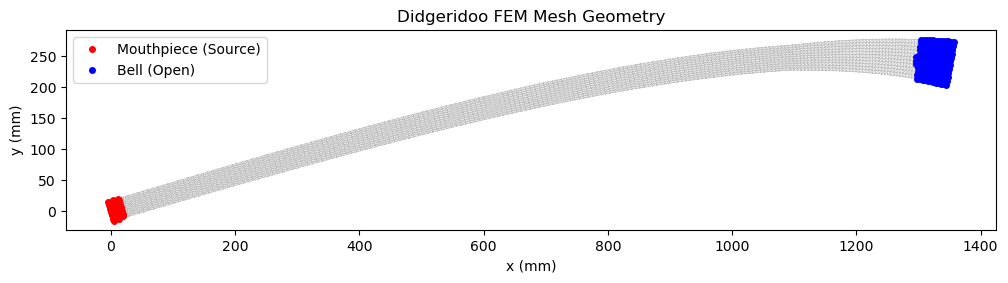

In [23]:
def get_didgeridoo_mesh(segments, curve_func, n_z=200, n_r=12):
    """Creates a 2D mesh wrapped around a parametric curve."""
    z_min, z_max = segments[0, 0], segments[-1, 0]
    z_vals = np.linspace(z_min, z_max, n_z)
    r_vals = np.linspace(-1, 1, n_r)
    
    mesh_log = fem.MeshTri.init_tensor(z_vals, r_vals)
    new_p = np.zeros_like(mesh_log.p)
    
    for i in range(mesh_log.p.shape[1]):
        s_val = mesh_log.p[0, i]
        rel_r = mesh_log.p[1, i]
        
        p0 = curve_func(s_val)
        p_eps = curve_func(s_val + 0.1) 
        tangent = (p_eps - p0) / np.linalg.norm(p_eps - p0)
        normal = np.array([-tangent[1], tangent[0]])
        
        radius = np.interp(s_val, segments[:, 0], segments[:, 1]) / 2.0
        new_p[:, i] = p0 + (radius * rel_r * normal)
        
    return fem.MeshTri(new_p, mesh_log.t)

def plot_didgeridoo_mesh(mesh, mouth_idx=None, bell_idx=None):
    """Visualizes the generated FEM mesh and boundary regions."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the triangular elements
    ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, color='gray', lw=0.5, alpha=0.5)
    
    # Highlight Mouthpiece nodes
    if mouth_idx is not None:
        ax.plot(mesh.p[0, mouth_idx], mesh.p[1, mouth_idx], 'ro', markersize=4, label='Mouthpiece (Source)')
        
    # Highlight Bell nodes
    if bell_idx is not None:
        ax.plot(mesh.p[0, bell_idx], mesh.p[1, bell_idx], 'bo', markersize=4, label='Bell (Open)')

    ax.set_aspect('equal')
    ax.set_title("Didgeridoo FEM Mesh Geometry")
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.legend()
    plt.show()

plot_didgeridoo_mesh(mesh, mouth_idx, bell_idx)

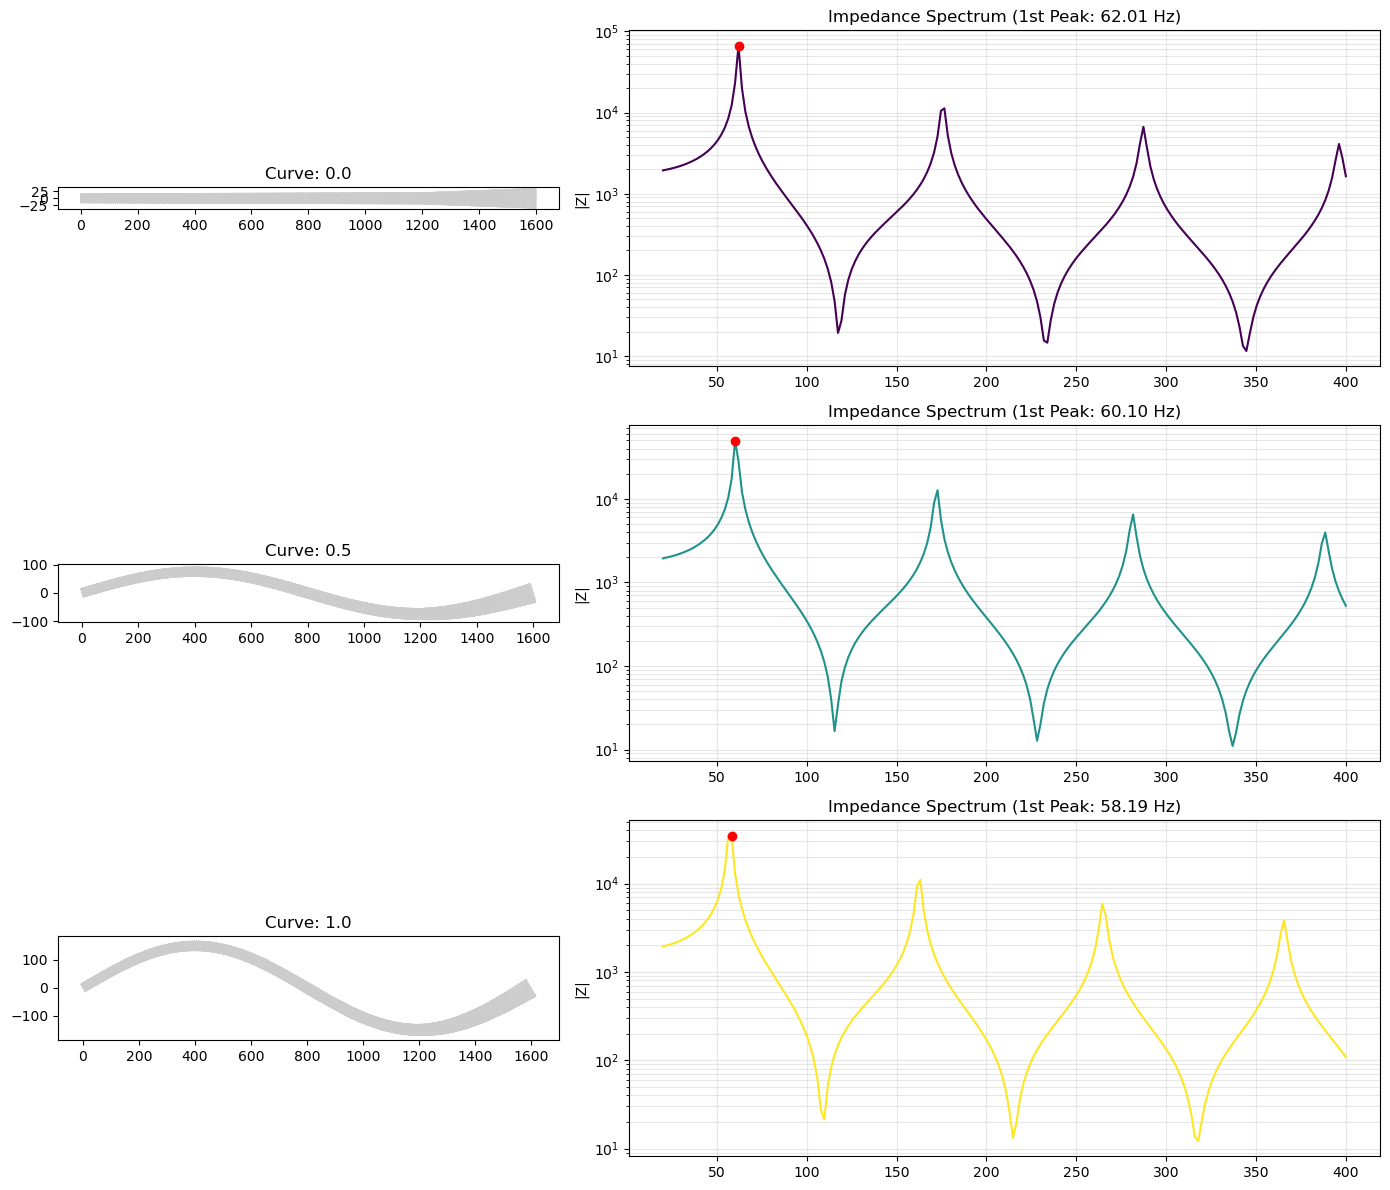

In [28]:
import numpy as np
import skfem as fem
from skfem.helpers import dot, grad
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- CONSTANTS ---
C_SPEED = 343000.0  # mm/s

# --- 1. GEOMETRY & MESHING ---

def get_didgeridoo_mesh(segments, curve_func, n_z=250, n_r=12):
    z_min, z_max = segments[0, 0], segments[-1, 0]
    z_vals = np.linspace(z_min, z_max, n_z)
    r_vals = np.linspace(-1, 1, n_r)
    
    mesh_log = fem.MeshTri.init_tensor(z_vals, r_vals)
    new_p = np.zeros_like(mesh_log.p)
    
    for i in range(mesh_log.p.shape[1]):
        s_val = mesh_log.p[0, i]
        rel_r = mesh_log.p[1, i]
        
        p0 = curve_func(s_val)
        p_eps = curve_func(s_val + 0.1) 
        diff = p_eps - p0
        dist = np.linalg.norm(diff)
        
        tangent = diff / dist if dist > 0 else np.array([1.0, 0.0])
        normal = np.array([-tangent[1], tangent[0]])
        
        radius = np.interp(s_val, segments[:, 0], segments[:, 1]) / 2.0
        new_p[:, i] = p0 + (radius * rel_r * normal)
        
    return fem.MeshTri(new_p, mesh_log.t)

def plot_didgeridoo_mesh(ax, mesh, title="Mesh"):
    ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, color='gray', lw=0.5, alpha=0.4)
    ax.set_aspect('equal')
    ax.set_title(title)

# --- 2. FEM & ANALYSIS ---

def get_flat_indices(dofs):
    if isinstance(dofs, dict):
        return np.concatenate([v for v in dofs.values()]).astype(int)
    return dofs.astype(int)

def run_analysis(mesh, segments, curve_func, frequencies):
    basis = fem.Basis(mesh, fem.ElementTriP1())
    
    @fem.BilinearForm
    def stiffness(u, v, w): return dot(grad(u), grad(v))
    @fem.BilinearForm
    def mass(u, v, w): return u * v

    K = stiffness.assemble(basis)
    M = mass.assemble(basis)
    
    bell_pt = curve_func(segments[-1, 0])
    mouth_pt = curve_func(segments[0, 0])
    
    bell_idx = get_flat_indices(basis.get_dofs(lambda x: np.linalg.norm(x - bell_pt[:, None], axis=0) < 80).nodal)
    mouth_idx = get_flat_indices(basis.get_dofs(lambda x: np.linalg.norm(x - mouth_pt[:, None], axis=0) < 20).nodal)
    
    b_mouth = np.zeros(basis.N)
    b_mouth[mouth_idx] = 1.0
    
    z_spectrum = []
    for f in frequencies:
        omega = 2 * np.pi * f
        k = (omega / C_SPEED) - 1j * (1.5e-6 * np.sqrt(f))
        A = K - (k**2) * M
        p = fem.solve(*fem.condense(A, b_mouth, D=bell_idx))
        z_spectrum.append(np.mean(np.abs(p[mouth_idx])))
        
    return np.array(z_spectrum)

# --- 3. MAIN EXECUTION ---

if __name__ == "__main__":
    my_segments = np.array([[0, 32], [1200, 40], [1600, 70]])
    freqs = np.linspace(20, 400, 200) # Increased resolution for peak accuracy
    
    curve_levels = [0.0, 0.5, 1.0]
    fig, axes = plt.subplots(len(curve_levels), 2, figsize=(14, 12), gridspec_kw={'width_ratios': [1, 1.5]})

    for i, c_val in enumerate(curve_levels):
        def sine_curve(s, curve=c_val):
            amplitude = 150 * curve
            wavelength = 1600 
            y = amplitude * np.sin(2 * np.pi * s / wavelength)
            return np.array([s, y])

        # Analysis
        mesh = get_didgeridoo_mesh(my_segments, sine_curve)
        spectrum = run_analysis(mesh, my_segments, sine_curve, freqs)
        
        # Find the first peak
        peaks, _ = find_peaks(spectrum)
        if len(peaks) > 0:
            first_peak_freq = freqs[peaks[0]]
            peak_label = f" (1st Peak: {first_peak_freq:.2f} Hz)"
        else:
            peak_label = " (No peak found)"
            first_peak_freq = None

        # Plot Geometry
        plot_didgeridoo_mesh(axes[i, 0], mesh, title=f"Curve: {c_val}")
        
        # Plot Impedance
        axes[i, 1].semilogy(freqs, spectrum, label=f"Curve={c_val}", color=plt.cm.viridis(c_val))
        axes[i, 1].set_title(f"Impedance Spectrum{peak_label}")
        axes[i, 1].grid(True, which='both', alpha=0.3)
        axes[i, 1].set_ylabel("|Z|")
        
        # Mark the peak on the chart
        if first_peak_freq:
            axes[i, 1].plot(first_peak_freq, spectrum[peaks[0]], 'ro')

    plt.tight_layout()
    plt.show()